# Package import

In [24]:
import pickle
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV
import matplotlib as plt

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataPath = "/content/drive/MyDrive/ML_final_project/train_clean.pkl"

# Data Import

In [4]:
train = pickle.load(open(dataPath, "rb"))

In [26]:
train.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,walkDistance,weaponsAcquired,winPoints,winPlacePerc,total_distance,health_items,headhshot_perc,teamwork,killStreak_len,totalHits
2353172,0,1,382.75,4,0,0,7,0,4,2,...,365.00,4,0,0.428711,365.00,1,0.0,1,0.5,8
877513,0,2,180.00,1,1,1,17,0,2,2,...,1214.00,4,0,0.710938,4704.00,3,0.5,2,1.0,3
3970094,0,0,136.75,1,0,0,43,1401,0,0,...,2760.00,5,1505,0.714355,2820.00,0,0.0,1,0.0,1
1828839,0,4,470.00,2,0,2,2,0,5,2,...,1664.00,6,0,0.708496,1664.00,6,0.0,0,0.4,7
1554837,0,0,100.00,1,0,0,85,0,0,0,...,76.25,1,0,0.076904,76.25,0,0.0,0,0.0,1


In [6]:
#random select data
train = train.sample(frac =.50)

# Features engineer

In [27]:
numerical_cols = list(train.columns)
numerical_cols.remove('matchType')
numerical_cols.remove('winPlacePerc')

In [28]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train, test_size=0.2, random_state=5)

In [29]:
train_inputs = train_df.drop(columns=['winPlacePerc'])
y_train = train_df['winPlacePerc']
valid_inputs = val_df.drop(columns=['winPlacePerc'])
y_valid = val_df['winPlacePerc']

In [30]:
from sklearn.preprocessing import StandardScaler

#creating instance of a StandardScaler
scaler = StandardScaler().fit(train_inputs[numerical_cols])

In [31]:
#scaling the numeric features
train_inputs[numerical_cols] = scaler.transform(train_inputs[numerical_cols])
valid_inputs[numerical_cols] = scaler.transform(valid_inputs[numerical_cols])

In [32]:
from sklearn.preprocessing import OneHotEncoder
#encoding categorical features
cat_cols = ['matchType']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train[cat_cols])
category_cols = list(encoder.get_feature_names(cat_cols))
train_inputs[category_cols] = encoder.transform(train_inputs[cat_cols])

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(valid_inputs[cat_cols])
category_cols = list(encoder.get_feature_names(cat_cols))
valid_inputs[category_cols] = encoder.transform(valid_inputs[cat_cols])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
#including both columns to get the dataframe that we can put through the model
X_train = train_inputs[numerical_cols + category_cols]
X_valid = valid_inputs[numerical_cols + category_cols]

# XGBoost

In [34]:
import xgboost
from xgboost import XGBRegressor
import math
import matplotlib as plt

In [35]:
xgbm = XGBRegressor(random_state=5)
xgbm.fit(X_train, y_train)
y_pred_train_xgbm = xgbm.predict(X_train)
y_pred_valid_xgbm = xgbm.predict(X_valid)

[00:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [37]:
xgbm_train_mae = mean_absolute_error(y_train, y_pred_train_xgbm)
xgbm_valid_mae = mean_absolute_error(y_valid, y_pred_valid_xgbm)
xgbm_train_rmse = math.sqrt(mean_squared_error(y_train, y_pred_train_xgbm))
xgbm_valid_rmse = math.sqrt(mean_squared_error(y_valid, y_pred_valid_xgbm))
print("Training Mean Absolute Error: ", xgbm_train_mae)
print("Validation Mean Absolute Error: ", xgbm_valid_mae)
print("Training RMSE: ", xgbm_train_rmse)
print("Validation RMSE: ", xgbm_valid_rmse)

Training Mean Absolute Error:  0.0767425
Validation Mean Absolute Error:  0.07671892
Training RMSE:  0.1076410701511042
Validation RMSE:  0.10767526651719905


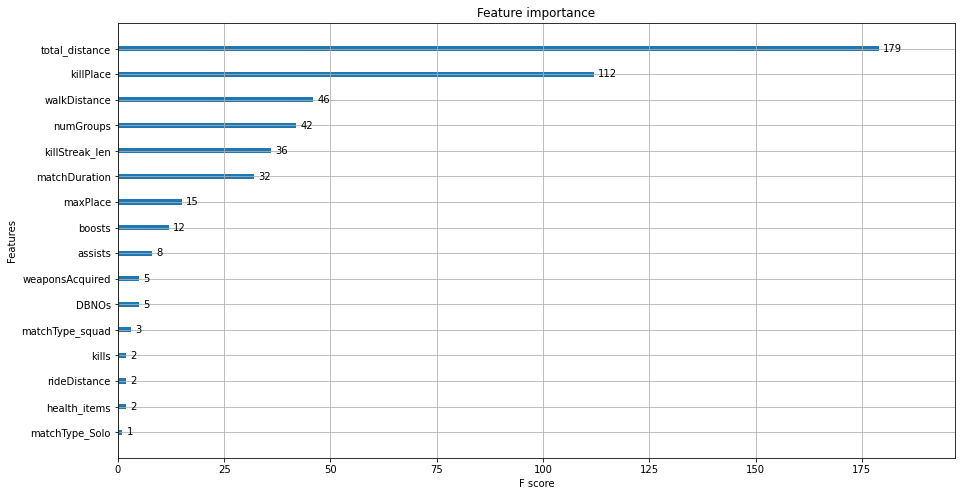

In [32]:
fig, ax1 = plt.pyplot.subplots(figsize=(15,8))
xgboost.plot_importance(xgbm, ax=ax1)
#plt.show()

# LGB

In [14]:
from lightgbm import LGBMRegressor

In [15]:
lgbm = LGBMRegressor(random_state=5, n_jobs=-1)
lgbm.fit(X_train, y_train)
y_pred_train_lgbm = lgbm.predict(X_train)
y_pred_valid_lgbm = lgbm.predict(X_valid)

In [22]:
lgbm_train_mae = mean_absolute_error(y_train, y_pred_train_lgbm)
lgbm_valid_mae = mean_absolute_error(y_valid, y_pred_valid_lgbm)
lgbm_train_rmse = math.sqrt(mean_squared_error(y_train, y_pred_train_lgbm))
lgbm_valid_rmse = math.sqrt(mean_squared_error(y_valid, y_pred_valid_lgbm))
print("Training Mean Absolute Error: ", lgbm_train_mae)
print("Validation Mean Absolute Error: ", lgbm_valid_mae)
print("Training RMSE: ", lgbm_train_rmse)
print("Validation RMSE: ", lgbm_valid_rmse)

Training Mean Absolute Error:  0.05940779222228924
Validation Mean Absolute Error:  0.059491111624168175
Training RMSE:  0.08263715094126749
Validation RMSE:  0.0828748552271403


In [ ]:
parameters = {
    'task' : ['predict'],
    'boosting': ['gbdt' ],
    'objective': ['root_mean_squared_error'],
    'num_iterations': [300, 800, 1000],
    'learning_rate':[0.05, 0.005],
   'num_leaves':[7, 15, 31],
   'max_depth' :[10,15,25],
   'min_data_in_leaf':[15, 25],
  'feature_fraction': [0.6, 0.8,  0.9],
    'bagging_fraction': [0.6, 0.8],
    'bagging_freq': [100, 200, 400],
}

lgb_model = LGBMRegressor()
gsearch_lgb = GridSearchCV(lgb_model, param_grid = parameters, n_jobs=6, cv = 5, verbose=10)
gsearch_lgb.fit(X_train,y_train)
 

print('best params')
print (gsearch_lgb.best_params_)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
